In [1]:
import re
import os
from os.path import join
import time
import scipy
from scipy import sparse as sp
import copy as cp
import itertools
import logging
import numpy as np
import pandas as pd
import networkx as nx
import sklearn
from sklearn import metrics
from sklearn import preprocessing as p

import torch
from torch import nn
import torch.sparse as sparse
import torchtuples as tt
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sksurv.metrics import concordance_index_censored

import captum
from captum.attr import IntegratedGradients
from captum.attr import DeepLift
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
reactome_base_dir = '/home/yincheng23/MultOmic/LIHC/Lnet/Reactome2021/'
relations_file_name = 'ReactomePathwaysRelation.txt'
pathway_names = 'ReactomePathways.txt'
pathway_genes = 'ReactomePathways.gmt'

class GMT():
    def load_data(self, filename, genes_col=1, pathway_col=0):
        data_dict_list = []
        with open(filename) as gmt:
            data_list = gmt.readlines()
            for row in data_list:
                genes = row.strip().split('\t')
                genes = [re.sub('_copy.*', '', g) for g in genes]
                genes = [re.sub('\\n.*', '', g) for g in genes]
                for gene in genes[genes_col:]:
                    pathway = genes[pathway_col]
                    dict = {'group': pathway, 'gene': gene}
                    data_dict_list.append(dict)
        return pd.DataFrame(data_dict_list)

def add_edges(G, node, n_levels):
    edges = []
    source = node
    for l in range(n_levels):
        target = node + '_copy' + str(l + 1)
        edge = (source, target)
        source = target
        edges.append(edge)

    G.add_edges_from(edges)
    return G

def complete_network(G, n_leveles=4):
    sub_graph = nx.ego_graph(G, 'root', radius=n_leveles)
    terminal_nodes = [n for n, d in sub_graph.out_degree() if d == 0]
    distances = [len(nx.shortest_path(G, source='root', target=node)) for node in terminal_nodes]
    for node in terminal_nodes:
        distance = len(nx.shortest_path(sub_graph, source='root', target=node))
        if distance <= n_leveles:
            diff = n_leveles - distance + 1
            sub_graph = add_edges(sub_graph, node, diff)
    return sub_graph

def get_nodes_at_level(net, distance):
    nodes = set(nx.ego_graph(net, 'root', radius=distance))
    if distance >= 1.:
        nodes -= set(nx.ego_graph(net, 'root', radius=distance - 1))
    return list(nodes)


def get_layers_from_net(net, n_levels):
    layers = []
    for i in range(n_levels):
        nodes = get_nodes_at_level(net, i)
        dict = {}
        for n in nodes:
            n_name = re.sub('_copy.*', '', n)
            next = net.successors(n)
            dict[n_name] = [re.sub('_copy.*', '', nex) for nex in next]
        layers.append(dict)
    return layers


class Reactome():
    def __init__(self):
        self.pathway_names = self.load_names()
        self.hierarchy = self.load_hierarchy()
        self.pathway_genes = self.load_genes()

    def load_names(self):
        filename = join(reactome_base_dir, pathway_names)
        df = pd.read_csv(filename, sep='\t')
        df.columns = ['reactome_id', 'pathway_name', 'species']
        return df

    def load_genes(self):
        filename = join(reactome_base_dir, pathway_genes)
        gmt = GMT()
        df = gmt.load_data(filename, pathway_col=1, genes_col=3)
        return df

    def load_hierarchy(self):
        filename = join(reactome_base_dir, relations_file_name)
        df = pd.read_csv(filename, sep='\t')
        df.columns = ['child', 'parent']
        return df


class ReactomeNetwork():
    def __init__(self):
        self.reactome = Reactome()  # low level access to reactome pathways and genes
        self.netx = self.get_reactome_networkx()

    def get_terminals(self):
        terminal_nodes = [n for n, d in self.netx.out_degree() if d == 0]
        return terminal_nodes

    def get_roots(self):
        roots = get_nodes_at_level(self.netx, distance=1)
        return roots

    def get_reactome_networkx(self):
        if hasattr(self, 'netx'):
            return self.netx
        hierarchy = self.reactome.hierarchy
        human_hierarchy = hierarchy[hierarchy['child'].str.contains('HSA')]
        net = nx.from_pandas_edgelist(human_hierarchy, 'child', 'parent', create_using=nx.DiGraph())
        net.name = 'reactome'
        roots = [n for n, d in net.in_degree() if d == 0]
        root_node = 'root'
        edges = [(root_node, n) for n in roots]
        net.add_edges_from(edges)
        return net

    def info(self):
        return nx.info(self.netx)

    def get_tree(self):
        G = nx.bfs_tree(self.netx, 'root')
        return G

    def get_completed_network(self, n_levels):
        G = complete_network(self.netx, n_leveles=n_levels)
        return G

    def get_completed_tree(self, n_levels):
        G = self.get_tree()
        G = complete_network(G, n_leveles=n_levels)
        return G

    def get_layers(self, n_levels, direction='root_to_leaf'):
        if direction == 'root_to_leaf':
            net = self.get_completed_network(n_levels)
            layers = get_layers_from_net(net, n_levels)
        else:
            net = self.get_completed_network(5)
            layers = get_layers_from_net(net, 5)
            layers = layers[5 - n_levels:5]

        terminal_nodes = [n for n, d in net.out_degree() if d == 0]  # set of terminal pathways
        genes_df = self.reactome.pathway_genes

        dict = {}
        missing_pathways = []
        for p in terminal_nodes:
            pathway_name = re.sub('_copy.*', '', p)
            genes = genes_df[genes_df['group'] == pathway_name]['gene'].unique()
            if len(genes) == 0:
                missing_pathways.append(pathway_name)
            dict[pathway_name] = genes

        layers.append(dict)
        return layers
    

reactome = Reactome()
names_df = reactome.pathway_names
hierarchy_df = reactome.hierarchy
genes_df = reactome.pathway_genes
reactome_net = ReactomeNetwork()

print('# of root nodes {} , # of terminal nodes {}'.format(len(reactome_net.get_roots()),
                                                           len(reactome_net.get_terminals())))

layers = reactome_net.get_layers(n_levels=4)
print(len(layers))


def get_map_from_layer(layer_dict):
    '''
    :param layer_dict: dictionary of connections (e.g {'pathway1': ['g1', 'g2', 'g3']}
    :return: dataframe map of layer (index = genes, columns = pathways, , values = 1 if connected; 0 else)
    '''
    pathways = layer_dict.keys()
    genes = list(itertools.chain.from_iterable(layer_dict.values()))
    genes = list(np.unique(genes))
    df = pd.DataFrame(index=pathways, columns=genes)
    for k, v in layer_dict.items():
        df.loc[k, v] = 1
    df = df.fillna(0)
    return df.T

print('----')
for i, layer in enumerate(layers[::-1]):
    print(i)
    mapp = get_map_from_layer(layer)
    if i == 0:
        genes = list(mapp.index)#[0:5]
    filter_df = pd.DataFrame(index=genes)
    all = filter_df.merge(mapp, right_index=True, left_index=True, how='inner')
    genes = list(mapp.columns)
    print(all.shape)

# of root nodes 28 , # of terminal nodes 1774
5
----
0
(10189, 1100)
1
(1100, 488)
2
(488, 159)
3
(159, 28)
4
(28, 1)


In [7]:
class SparseLayer(nn.Module):
    def __init__(self, n_output, mapping, activation='tanh', l2_reg=0.001, use_bias=True, 
                 kernel_initializer='glorot_uniform', kernel_regularizer=True, 
                 bias_initializer='zeros', bias_regularizer=None, device='cpu'):
        super(SparseLayer, self).__init__()
        self.n_input, self.n_output = mapping.shape
        self.mapping = torch.tensor(mapping, dtype=torch.float64, device=device)
        self.nonzero_ind = torch.tensor(np.array(np.nonzero(mapping)).T, dtype=torch.long, device=device)
        self.nonzero_count = self.nonzero_ind.shape[0]
        self.activation = activation
        self.use_bias = use_bias
        self.l2_reg = l2_reg if kernel_regularizer is not None else 0.0
        self.device = device

        if kernel_initializer == 'glorot_uniform':
            limit = np.sqrt(6 / (self.n_input + self.n_output))
            kernel_init = torch.FloatTensor(self.nonzero_count).uniform_(-limit, limit)
        else:
            kernel_init = torch.zeros(self.nonzero_count)

        self.kernel_vector = nn.Parameter(kernel_init.to(device, dtype=torch.float64))
        
        if use_bias:
            self.bias = nn.Parameter(torch.zeros(n_output, device=device) if bias_initializer == 'zeros' else torch.randn(n_output, device=device))
        else:
            self.bias = None

    def forward(self, x):
        kernel = torch.zeros(self.n_input, self.n_output, device=self.device, dtype=torch.float64)
        kernel.index_put_(tuple(self.nonzero_ind.t()), self.kernel_vector)
        out = torch.matmul(x, kernel)
        if self.use_bias:
            out = out + self.bias
        if self.activation == 'tanh':
            out = torch.tanh(out)
        elif self.activation == 'relu':
            out = F.relu(out)
        elif self.activation == 'sigmoid':
            out = torch.sigmoid(out)
        return out

    def l2_loss(self):
        return self.l2_reg * torch.sum(self.kernel_vector ** 2) if self.l2_reg > 0 else 0.0


class PNet(nn.Module):
    def __init__(self, gene_list, n_omic, n_hidden_layers=4, direction='root_to_leaf', 
                 activation='tanh', activation_decision='linear', w_reg=0.01, w_reg_outcomes=0.0001, 
                 dropout=0.3, sparse=True, add_unk_genes=False, batch_normal=False, 
                 shuffle_genes=False, dropout_testing=False, non_neg=False, 
                 sparse_first_layer=True, device='cpu'):
        super(PNet, self).__init__()
        self.n_omic = n_omic
        self.n_features = len(gene_list)
        self.gene_list = gene_list
        self.n_hidden_layers = n_hidden_layers
        self.direction = direction
        self.activation = activation
        self.activation_decision = activation_decision
        self.dropout = dropout if isinstance(dropout, list) else [dropout] * 10
        self.w_reg = w_reg if isinstance(w_reg, list) else [w_reg] * 10
        self.w_reg_outcomes = w_reg_outcomes
        self.sparse = sparse
        self.add_unk_genes = add_unk_genes
        self.batch_normal = batch_normal
        self.shuffle_genes = shuffle_genes
        self.dropout_testing = dropout_testing
        self.non_neg = non_neg
        self.sparse_first_layer = sparse_first_layer
        self.device = device

        self.combine_layer = nn.ModuleList([nn.Linear(n_omic, 1, bias=False) for _ in range(self.n_features)])
        self.reactome_net = ReactomeNetwork()
        self.layers = nn.ModuleList()
        self.decision_layers = nn.ModuleList()
        self.feature_names = {}
        self.bn_layers = nn.ModuleList() if batch_normal else None

        self.maps = self.get_layer_maps(n_hidden_layers, direction)
        n_layers = len(self.maps)

        if sparse and sparse_first_layer:
            gene_map = self.maps[0]
            if gene_map.shape[0] != self.n_features:
                raise ValueError(f"Feature dimension mismatch: expected {self.n_features}, got {gene_map.shape[0]}")
            if shuffle_genes == 'all':
                gene_map = self.shuffle_genes_map(gene_map)
            self.layers.append(SparseLayer(self.n_features, gene_map, activation=activation, 
                                          l2_reg=self.w_reg[0], device=device))
        else:
            self.layers.append(nn.Linear(self.n_features, self.n_features, bias=False))
        self.decision_layers.append(nn.Linear(self.n_features, 1, bias=False))
        if batch_normal:
            self.bn_layers.append(nn.BatchNorm1d(1))
        self.feature_names['h0'] = self.gene_list

        for i in range(1, n_layers):
            mapp = self.maps[i].values
            if shuffle_genes in ['all', 'pathways']:
                mapp = self.shuffle_genes_map(mapp)
            n_input, n_output = mapp.shape
            if sparse:
                self.layers.append(SparseLayer(n_output, mapp, activation=activation, 
                                              l2_reg=self.w_reg[i], device=device))
            else:
                self.layers.append(nn.Linear(n_input, n_output, bias=False))
            self.decision_layers.append(nn.Linear(n_output, 1, bias=False))
            if batch_normal:
                self.bn_layers.append(nn.BatchNorm1d(1))
            self.feature_names[f'h{i}'] = self.maps[i].columns

    def get_layer_maps(self, n_levels, direction):
        maps = []
        mat = np.eye(self.n_features)
        maps.append(mat)

        layers = self.reactome_net.get_layers(n_levels, direction)
        filtering_index = self.gene_list
        
        for i, layer in enumerate(layers[::-1]):
            mapp = self.get_map_from_layer(layer)
            filter_df = pd.DataFrame(index=filtering_index)
            filtered_map = filter_df.merge(mapp, right_index=True, left_index=True, how='left')
            if self.add_unk_genes and i == len(layers) - 1:
                filtered_map['UNK'] = 0
                ind = filtered_map.sum(axis=1) == 0
                filtered_map.loc[ind, 'UNK'] = 1
            filtered_map = filtered_map.fillna(0)
            filtering_index = filtered_map.columns
            logging.info(f'Layer {i+1}, # of edges {filtered_map.sum().sum()}')
            maps.append(filtered_map)
        
        return maps

    def get_map_from_layer(self, layer_dict):
        pathways = list(layer_dict.keys())
        genes = list(np.unique(list(itertools.chain.from_iterable(layer_dict.values()))))
        n_pathways, n_genes = len(pathways), len(genes)
        mat = np.zeros((n_pathways, n_genes))
        for p, gs in layer_dict.items():
            g_inds = [genes.index(g) for g in gs if g in genes]
            p_ind = pathways.index(p)
            mat[p_ind, g_inds] = 1
        return pd.DataFrame(mat, index=pathways, columns=genes).T

    def shuffle_genes_map(self, mapp):
        ones_ratio = np.sum(mapp) / np.prod(mapp.shape)
        return np.random.choice([0, 1], size=mapp.shape, p=[1 - ones_ratio, ones_ratio])

    def forward(self, x):
        outputs = []
        for i in range(self.n_features):
            raw_weights = self.combine_layer[i].weight
            norm_weights = torch.softmax(raw_weights, dim=1)
            combined = torch.matmul(x[:, i, :], norm_weights.T)
            outputs.append(combined)
        x_combined = torch.cat(outputs, dim=1)

        out = self.layers[0](x_combined)
        for i in range(1, len(self.layers)):
            out = self.layers[i](out)
            out = F.dropout(out, p=self.dropout[0], training=self.dropout_testing)
        return out 
        
        #out = self.layers[0](x_combined)
        #out = F.dropout(out, p=self.dropout[0], training=self.dropout_testing)
        #decision = self.decision_layers[0](out)
        #if self.batch_normal:
        #    decision = self.bn_layers[0](decision)
        #decision = decision if self.activation_decision == 'linear' else F.relu(decision)
        #decision_outcomes = [decision]
        #for i in range(1, len(self.layers)):
        #    out = self.layers[i](out)
        #    out = F.dropout(out, p=self.dropout[i], training=self.dropout_testing)
        #    decision = self.decision_layers[i](out)
        #    if self.batch_normal and i < len(self.bn_layers):
        #        decision = self.bn_layers[i](decision)
        #    decision = decision if self.activation_decision == 'linear' else F.relu(decision)
        #    decision_outcomes.append(decision)
        #return decision_outcomes
    
    def combined_forward(self, x_after_combine):
        out = self.layers[0](x_after_combine)
        for i in range(1, len(self.layers)):
            out = self.layers[i](out)
        return out 
        
        #out = self.layers[0](x_after_combine)
        #out = F.dropout(out, p=self.dropout[0], training=self.dropout_testing)
        #decision = self.decision_layers[0](out)
        #if self.batch_normal:
        #    decision = self.bn_layers[0](decision)
        #decision = decision if self.activation_decision == 'linear' else F.relu(decision)
        #decision_outcomes = [decision]
        #for i in range(1, len(self.layers)):
        #    out = self.layers[i](out)
        #    out = F.dropout(out, p=self.dropout[i], training=self.dropout_testing)
        #    decision = self.decision_layers[i](out)
        #    if self.batch_normal and i < len(self.bn_layers):
        #        decision = self.bn_layers[i](decision)
        #    decision = decision if self.activation_decision == 'linear' else F.relu(decision)
        #    decision_outcomes.append(decision)
        return decision_outcomes
    
    
    def weight_regularization(self):
        l2 = 0
        for layer in self.layers:
            if hasattr(layer, 'l2_loss'):
                l2 += layer.l2_loss()
        return l2
    
    def pred_regularization(self):
        l1_loss = 0
        for layer in self.decision_layers:
            if isinstance(layer, nn.Linear):
                l1_loss += torch.norm(layer.weight, p=1)
        return self.w_reg_outcomes * l1_loss

class CoxPHLoss(nn.Module):
    def forward(self, log_h, durations, events):
        return cox_ph_loss(log_h, durations, events)

def cox_ph_loss(log_h, durations, events, eps = 1e-7):
    idx = durations.sort(descending=True)[1]
    events = events[idx]
    log_h = log_h[idx]
    return cox_ph_loss_sorted(log_h, events, eps)

def cox_ph_loss_sorted(log_h, events, eps = 1e-7):
    if events.dtype is torch.bool:
        events = events.float()
    events = events.view(-1)
    log_h = log_h.view(-1)
    gamma = log_h.max()
    log_cumsum_h = log_h.sub(gamma).exp().cumsum(0).add(eps).log().add(gamma)
    return - log_h.sub(log_cumsum_h).mul(events).sum().div(events.sum())

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
os.chdir('/home/yincheng23/MultOmic/LIHC/Lnet/')
X1 = pd.read_csv('frame_shift.csv',index_col=0)
X2 = pd.read_csv('in_frame.csv',index_col=0)
X3 = pd.read_csv('other_type.csv',index_col=0)
X4 = pd.read_csv('missense.csv',index_col=0)
#X5 = pd.read_csv('mRNA.csv',index_col=0)
share = [s for s in X3.index if s in X4.index]
y = pd.read_csv('my_clinical.csv',index_col=0)
y = y.loc[share,['vital_status','days_to_death']]
y['vital_status'] = [1 if a == 'Dead' else 0 for a in y['vital_status']]

X1 = X1.loc[share,:]
X2 = X2.loc[share,:]
X3 = X3.loc[share,:]
X4 = X4.loc[share,:]
#X5 = X5.loc[share, X4.columns]
print(X1.shape)
print(y.shape)

X1_ = p.MinMaxScaler().fit_transform(X1)
X2_ = p.MinMaxScaler().fit_transform(X2)
X3_ = p.MinMaxScaler().fit_transform(X3)
X4_ = p.MinMaxScaler().fit_transform(X4)
#X5_ = p.StandardScaler().fit_transform(X5)

(375, 14872)
(375, 2)


In [9]:
class MyData(Dataset):
    def __init__(self, X1, X2, X3, X4, y):
        self.n_samples = X1.shape[0]
        X1_ = torch.from_numpy(X1)
        X2_ = torch.from_numpy(X2)
        X3_ = torch.from_numpy(X3)
        X4_ = torch.from_numpy(X4)
        self.X = torch.stack([X1_, X2_, X3_, X4_], dim=-1)
        self.y = torch.from_numpy(y.to_numpy())

    def __getitem__(self, index):
        return {'X': self.X[index], 'y': self.y[index]}

    def __len__(self):
        return self.n_samples


dataset = MyData(X1_, X2_, X3_, X4_, y)
train_size = int(len(dataset)*0.6)
val_size = len(dataset) - train_size
print(train_size, '/', val_size)
train_dataset, val_dataset = random_split(dataset, lengths=[train_size, val_size])
train_loader = DataLoader(train_dataset, shuffle=True, batch_size= 128)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size= val_size)

225 / 150


In [10]:
gene_list = list(X1.columns)
model = PNet(gene_list=gene_list, n_omic=4, n_hidden_layers=3, device='cpu')
model = model.double()
criterion = CoxPHLoss()
lr = 0.001
optimizer = torch.optim.Adagrad(model.parameters(), lr=lr, weight_decay=1e-4)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
print(f'Number of parameters :{count_parameters(model)/1000000:.2f} million')

Number of parameters :0.13 million


In [11]:
max_epoch = 60
training_loss = []
training_ci = []
validation_loss = []
validation_ci = []
for epoch in range(1, max_epoch+1):
    t = time.time()
    loss_train = 0.0
    ci_train = 0.0
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        out = model(data['X'].double())
        event = data['y'][:,0]
        duration = data['y'][:,1]
        loss = criterion(out, duration, event)
        loss += model.weight_regularization()
        #loss += model.pred_regularization()
        loss.backward()
        optimizer.step()
        loss_train += loss.item()

        risk = out.exp().detach().numpy().reshape(-1)
        event_bool = [True if e == 1 else False for e in event]
        ci, n_con, n_dis, tiedr, tiedt = concordance_index_censored(event_bool, duration.numpy(), risk)
        ci_train += ci

    loss_train = loss_train/len(train_loader)
    ci_train = ci_train/len(train_loader)
    training_loss.append(loss_train)
    training_ci.append(ci_train)
    
    model.eval()
    with torch.no_grad():
        for data in val_loader:
            out = model(data['X'].double())
            event = data['y'][:,0]
            duration = data['y'][:,1]
            loss = criterion(out, duration, event)
            loss += model.weight_regularization()
            #loss += model.pred_regularization()
            loss_val = loss.item()

    risk = out.exp().detach().numpy().reshape(-1)
    event_bool = [True if e == 1 else False for e in event]
    ci_val, n_con, n_dis, tiedr, tiedt = concordance_index_censored(event_bool, duration.numpy(), risk)
    validation_loss.append(loss_val)
    validation_ci.append(ci_val)
    if epoch % 10 == 0:        
        print('====> Epoch: {} Training loss: {:.3f}, Training CI: {:.3f}, Validation CI: {:.3f}'.format(
               epoch, loss_train, ci_train, ci_val))

====> Epoch: 10 Training loss: 2.819, Training CI: 0.499, Validation CI: 0.477
====> Epoch: 20 Training loss: 2.811, Training CI: 0.510, Validation CI: 0.483
====> Epoch: 30 Training loss: 2.803, Training CI: 0.513, Validation CI: 0.495
====> Epoch: 40 Training loss: 2.803, Training CI: 0.515, Validation CI: 0.492
====> Epoch: 50 Training loss: 2.803, Training CI: 0.502, Validation CI: 0.500
====> Epoch: 60 Training loss: 2.791, Training CI: 0.500, Validation CI: 0.500


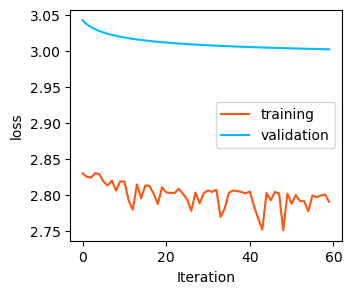

In [12]:
plt.figure(figsize=(3.5,3))
plt.plot(np.arange(len(training_loss)),  training_loss,   label='training', color='#FF5511')
plt.plot(np.arange(len(validation_loss)),validation_loss, label='validation', color='#00BBFF')
plt.xlabel('Iteration'); plt.ylabel('loss'); plt.legend()
#plt.yscale('log')
plt.show()

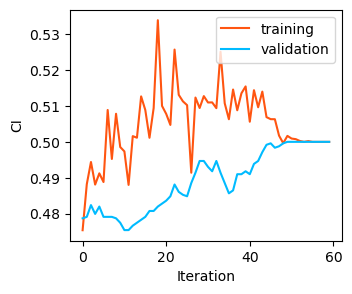

In [13]:
plt.figure(figsize=(3.5,3))
plt.plot(np.arange(len(training_ci)),  training_ci,   label='training', color='#FF5511')
plt.plot(np.arange(len(validation_ci)),validation_ci, label='validation', color='#00BBFF')
plt.xlabel('Iteration'); plt.ylabel('CI'); plt.legend()
#plt.ylim((0.45,1))
plt.show()

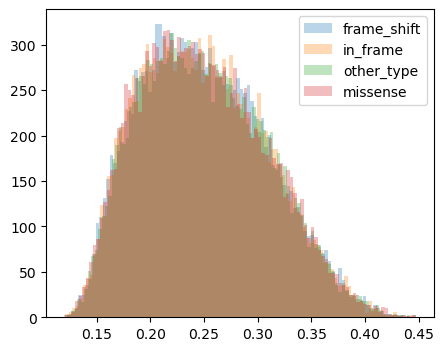

In [14]:
w = []
for i in range(len(gene_list)):
    tmp = F.softmax(model.combine_layer[i].weight.data, dim=1).numpy()[0]
    tmp = pd.DataFrame(tmp).T
    w.append(tmp)
w = pd.concat(w)
w.columns = ['frame_shift','in_frame','other_type','missense']
w.index = gene_list
plt.figure(figsize=(5,4))
plt.hist(w.iloc[:,0], 100, label = 'frame_shift',alpha=0.3)
plt.hist(w.iloc[:,1], 100, label = 'in_frame',alpha=0.3)
plt.hist(w.iloc[:,2], 100, label = 'other_type',alpha=0.3)
plt.hist(w.iloc[:,3], 100, label = 'missense',alpha=0.3)
plt.legend()
plt.show()

In [16]:
x = dataset.X.double()
model.eval()
with torch.no_grad():
    outputs = []
    for i in range(model.n_features):
        norm_weights = torch.softmax(model.combine_layer[i].weight, dim=1)
        combined = torch.matmul(x[:, i, :], norm_weights.T)
        outputs.append(combined)
    x_after_combine = torch.cat(outputs, dim=1) 
print('combination done')

ig = IntegratedGradients(model.combined_forward)
baseline = torch.zeros_like(x_after_combine, dtype=torch.double)
print('baseline done')

attributions, delta = ig.attribute(inputs=x_after_combine, 
                                   baselines=baseline, 
                                   target=0, 
                                   return_convergence_delta=True)
print('IG done')

print("Input shape (after combine_layer):", x_after_combine.shape)
print("Attributions shape:", attributions.shape)
mean_attributions = attributions.mean(dim=0)
print("Mean attributions per input_dim:", mean_attributions)

combination done
baseline done
IG done
Input shape (after combine_layer): torch.Size([375, 14872])
Attributions shape: torch.Size([375, 14872])
Mean attributions per input_dim: tensor([ 0.0000e+00,  0.0000e+00,  9.0700e-23,  ...,  0.0000e+00,
         0.0000e+00, -9.0064e-13], dtype=torch.float64)


In [17]:
top_n = 40
igv = mean_attributions.numpy()
protect_idx = np.argsort(igv)[0:top_n]
harmful_idx = np.argsort(igv)[-top_n:]

In [18]:
X1.columns[protect_idx]

Index(['SCN1A', 'SPTBN1', 'SLIT2', 'SPTA1', 'UTRN', 'PTPRC', 'OR4K2', 'KMT2C',
       'PBRM1', 'HLA-DQB2', 'PLXNB3', 'PLCB1', 'RTP1', 'LRRC41', 'IL21R',
       'RBP3', 'TSC2', 'PSMB10', 'OR5D18', 'OR4K1', 'RPL26', 'GRIN2A', 'PINK1',
       'HLA-DQA1', 'USP34', 'PIK3CB', 'DCC', 'OR10G2', 'PNRC2', 'CPT1A',
       'LGI3', 'HLA-DRB1', 'GNB5', 'SP1', 'CGN', 'CSK', 'EZR', 'DUSP16',
       'HHAT', 'ITGB3'],
      dtype='object')

In [19]:
X1.columns[harmful_idx]

Index(['WNT1', 'GTF2F1', 'GRM7', 'LCP2', 'APBB1', 'SLX4', 'ACTN3', 'CSF3R',
       'PIK3R1', 'NOS2', 'ARID1A', 'GNAT3', 'INPP5D', 'XPO1', 'PIK3R3',
       'OR6M1', 'HDAC2', 'COL16A1', 'OTOG', 'ABCA13', 'FGA', 'ADAM22', 'CHD9',
       'REV3L', 'TSC1', 'PTPRN2', 'PPP2R1B', 'OR5H1', 'VAV2', 'CNTN4', 'XIRP2',
       'AP3B1', 'EPB41L3', 'CTNNB1', 'OR2T8', 'AGO4', 'TUBB8B', 'COL6A3',
       'MYO15A', 'TP53'],
      dtype='object')

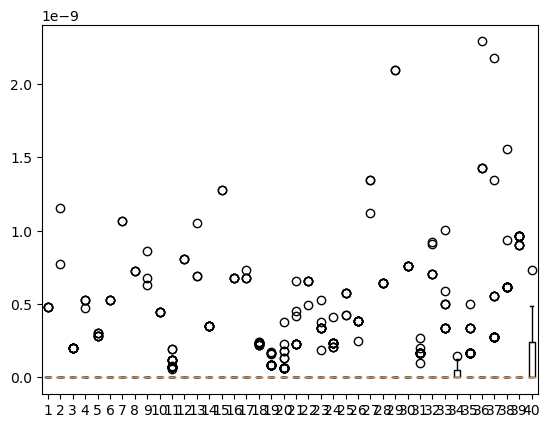

In [20]:
plt.boxplot(attributions[:,harmful_idx].numpy())
plt.show()

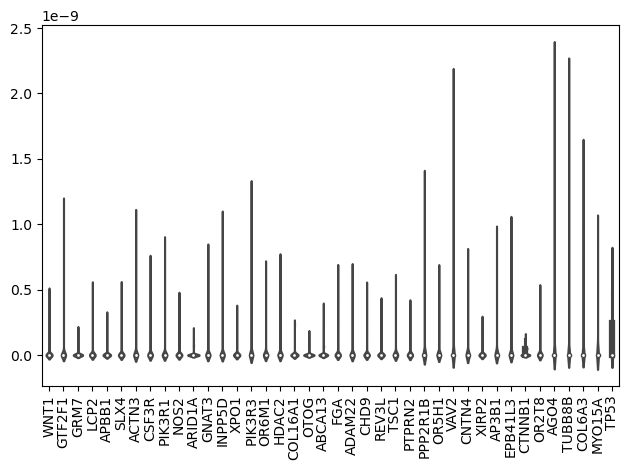

In [21]:
import seaborn as sns
ax = sns.violinplot(data=attributions[:,harmful_idx].numpy())
ax.set_xticklabels(X1.columns[harmful_idx])
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

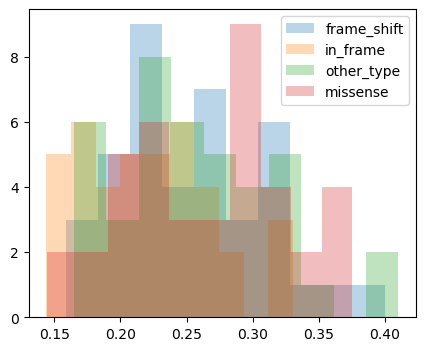

In [22]:
w = []
for i in harmful_idx:
    tmp = F.softmax(model.combine_layer[i].weight.data, dim=1).numpy()[0]
    tmp = pd.DataFrame(tmp).T
    w.append(tmp)
w = pd.concat(w)
w.columns = ['frame_shift','in_frame','other_type','missense']
w.index = X1.columns[harmful_idx]
plt.figure(figsize=(5,4))
plt.hist(w.iloc[:,0], label = 'frame_shift',alpha=0.3)
plt.hist(w.iloc[:,1], label = 'in_frame',alpha=0.3)
plt.hist(w.iloc[:,2], label = 'other_type',alpha=0.3)
plt.hist(w.iloc[:,3], label = 'missense',alpha=0.3)
plt.legend()
plt.show()

In [25]:
w[w['missense']>0.3]

,frame_shift,in_frame,other_type,missense
GRM7,0.174883,0.330538,0.183569,0.311010
ACTN3,0.158544,0.327656,0.172228,0.341572
PIK3R1,0.235132,0.239615,0.221115,0.304138
ARID1A,0.225443,0.173135,0.233477,0.367946
XPO1,0.305314,0.166086,0.224730,0.303870
PIK3R3,0.261548,0.149197,0.246568,0.342687
OR6M1,0.199407,0.204900,0.275433,0.320260
ADAM22,0.227124,0.243074,0.227126,0.302676
TSC1,0.261232,0.177176,0.207672,0.353921
PTPRN2,0.237833,0.204805,0.182234,0.375129


## backup

In [ ]:
max_epoch = 60
training_loss = []
training_ci = []
validation_loss = []
validation_ci = []
for epoch in range(1, max_epoch+1):
    t = time.time()
    loss_train = 0.0
    ci_train = 0.0
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        decision_outcomes = model(data['X'].double())
        event = data['y'][:,0]
        duration = data['y'][:,1]
        loss = 0.0
        for out in decision_outcomes:
            loss += criterion(out, duration, event)
        loss += model.weight_regularization()
        #loss += model.pred_regularization()
        loss.backward()
        optimizer.step()
        loss_train += loss.item()
        ci_vec = []
        for out in decision_outcomes:
            risk = out.exp().detach().numpy().reshape(-1)
            event_bool = [True if e == 1 else False for e in event]
            ci, n_con, n_dis, tiedr, tiedt = concordance_index_censored(event_bool, duration.numpy(), risk)
            ci_vec.append(ci)
        #print(ci_vec)
        ci_train += np.mean(ci_vec)

    loss_train = loss_train/len(train_loader)
    ci_train = ci_train/len(train_loader)
    training_loss.append(loss_train)
    training_ci.append(ci_train)
    
    model.eval()
    with torch.no_grad():
        for data in val_loader:
            decision_outcomes = model(data['X'].double())
            event = data['y'][:,0]
            duration = data['y'][:,1]
            loss = 0.0
            for out in decision_outcomes:
                loss =+ criterion(out, duration, event)
            loss += model.weight_regularization()
            #loss += model.pred_regularization()
            loss_val = loss.item()
    ci_vec = []
    for out in decision_outcomes:
        risk = out.exp().detach().numpy().reshape(-1)
        event_bool = [True if e == 1 else False for e in event]
        ci, n_con, n_dis, tiedr, tiedt = concordance_index_censored(event_bool, duration.numpy(), risk)
        ci_vec.append(ci)
    #print(ci_vec)
    ci_val = np.mean(ci_vec)
    validation_loss.append(loss_val)
    validation_ci.append(ci_val)
    if epoch % 10 == 0:        
        print('====> Epoch: {} Training loss: {:.3f}, Training CI: {:.3f}, Validation CI: {:.3f}'.format(
               epoch, loss_train, ci_train, ci_val))